# ONNX FFTs

Implementation of a couple of variations of FFT (see [FFT](https://www.tensorflow.org/xla/operation_semantics#fft) in ONNX.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## Signature

We try to use function [FFT](https://www.tensorflow.org/xla/operation_semantics#fft) or [torch.fft.fftn](https://pytorch.org/docs/stable/generated/torch.fft.fftn.html#torch.fft.fftn).

In [3]:
import numpy
from numpy.testing import assert_almost_equal

def numpy_fftn(x, fft_type, fft_length, axes):
    """
    Implements FFT

    :param x: input
    :param fft_type: string (see below)
    :param fft_length: length on each axis of axes
    :param axes: axes
    :return: result
    
    * `'FFT`': complex-to-complex FFT. Shape is unchanged.
    * `'IFFT`': Inverse complex-to-complex FFT. Shape is unchanged.
    * `'RFFT`': Forward real-to-complex FFT.
      Shape of the innermost axis is reduced to fft_length[-1] // 2 + 1 if fft_length[-1]
      is a non-zero value, omitting the reversed conjugate part of 
      the transformed signal beyond the Nyquist frequency.
    * `'IRFFT`': Inverse real-to-complex FFT (ie takes complex, returns real).
      Shape of the innermost axis is expanded to fft_length[-1] if fft_length[-1] 
      is a non-zero value, inferring the part of the transformed signal beyond the Nyquist
      frequency from the reverse conjugate of the 1 to fft_length[-1] // 2 + 1 entries.
    """
    if fft_type == 'FFT':
        return numpy.fft.fftn(x, fft_length, axes=axes)
    raise NotImplementedError("Not implemented for fft_type=%r." % fft_type)
    

def test_fct(fct1, fct2, fft_type='FFT', decimal=5):
    dims = [[4,4,4,4],
            [4,5,6,7]]
    lengths_axes = [([2, 2, 2, 2], None),
                    ([2, 6, 7, 2], None),
                    ([2, 3, 4, 5], None),
                    ([2], [3]),
                    ([3], [2])]
    n_test = 0
    for ndim in range(1, 5):
        for dim in dims:
            for length, axes in lengths_axes:
                if axes is None:
                    axes = range(ndim)
                axes = [min(ndim - 1, a) for a in axes]
                di = dim[:ndim]
                le = length[:ndim]
                mat = numpy.random.randn(*di).astype(numpy.float32)
                try:
                    v1 = fct1(mat, fft_type, le, axes=axes)
                except Exception as e:
                    raise AssertionError(
                        "Unable to run %r mat.shape=%r ndim=%r fft_type=%r le=%r "
                        "axes=%r exc=%r" %(
                            fct1, mat.shape, ndim, fft_type, le, axes, e))
                v2 = fct2(mat, fft_type, le, axes=axes)
                try:
                    assert_almost_equal(v1, v2, decimal=decimal)
                except AssertionError as e:
                    raise AssertionError(
                        "Failure mat.shape=%r, fft_type=%r, fft_length=%r" % (
                            mat.shape, fft_type, le)) from e
                n_test += 1
    return n_test
                    
test_fct(numpy_fftn, numpy_fftn)

40

In [4]:
import torch

def torch_fftn(x, fft_type, fft_length, axes):
    xt = torch.tensor(x)
    if fft_type == 'FFT':
        return torch.fft.fftn(xt, fft_length, axes).cpu().detach().numpy()
    
test_fct(numpy_fftn, torch_fftn)

40

## Numpy implementation

In [68]:
import numpy


def _dft_cst(N, fft_length, dtype):
    def _arange(dim, dtype, resh):
        return numpy.arange(dim).astype(dtype).reshape(resh)

    def _prod(n, k):
        return (-2j * numpy.pi * k / fft_length) * n

    def _exp(m):
        return numpy.exp(m)
    
    n = _arange(N, dtype, (-1, 1))
    k = _arange(fft_length, dtype, (1, -1))
    M = _exp(_prod(n, k))
    return M


def custom_fft(x, fft_type, length, axis):
    # https://github.com/numpy/numpy/blob/4adc87dff15a247e417d50f10cc4def8e1c17a03/numpy/fft/_pocketfft.py#L56
    if fft_type == 'FFT':
        if x.shape[axis] > length:
            # fft_length > shape on the same axis
            # the matrix is shortened
            slices = [slice(None)] * len(x.shape)
            slices[axis] = slice(0, length)
            new_x = x[tuple(slices)]
        elif x.shape[axis] == length:
            new_x = x
        else:
            # other, the matrix is completed with zeros
            shape = list(x.shape)
            shape[axis] = length
            slices = [slice(None)] * len(x.shape)
            slices[axis] = slice(0, length)
            zeros = numpy.zeros(tuple(shape), dtype=x.dtype)
            index = [slice(0, i) for i in x.shape]
            zeros[tuple(index)] = x
            new_x = zeros

        cst = _dft_cst(new_x.shape[axis], length, x.dtype)
        perm = numpy.arange(len(x.shape)).tolist()        
        if perm[axis] == perm[-1]:
            res = numpy.matmul(new_x, cst).transpose(perm)
        else:
            perm[axis], perm[-1] = perm[-1], perm[axis]            
            rest = new_x.transpose(perm)
            res = numpy.matmul(rest, cst).transpose(perm)
            perm[axis], perm[0] = perm[0], perm[axis]
        return res
    raise ValueError("Unexpected value for fft_type=%r." % fft_type)


def custom_fftn(x, fft_type, fft_length, axes):
    if len(axes) != len(fft_length):
        raise ValueError("Length mismatch axes=%r, fft_length=%r." % (
           axes, fft_length))
    if fft_type == 'FFT':
        res = x
        for i in range(len(fft_length) - 1, -1, -1):
            length = fft_length[i]
            axis = axes[i]
            res = custom_fft(res, fft_type, length, axis)
        return res
    raise ValueError("Unexpected value for fft_type=%r." % fft_type)

    
img = 1j
shape = (4, )
fft_length = [5,]
axes = [0]
rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * img
custom_fftn(rnd, 'FFT', fft_length, axes), numpy_fftn(rnd, 'FFT', fft_length, axes)
assert_almost_equal(custom_fftn(rnd, 'FFT', fft_length, axes),
                    numpy_fftn(rnd, 'FFT', fft_length, axes), decimal=5)

img = 1j
shape = (4, 3)
fft_length = [3, 2]
axes = [0, 1]
rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * img
custom_fftn(rnd, 'FFT', fft_length, axes), numpy_fftn(rnd, 'FFT', fft_length, axes)
assert_almost_equal(custom_fftn(rnd, 'FFT', fft_length, axes),
                    numpy_fftn(rnd, 'FFT', fft_length, axes), decimal=5)

In [69]:
test_fct(numpy_fftn, custom_fftn, decimal=4)

40

## Benchmark

In [70]:
from cpyquickhelper.numbers.speed_measure import measure_time
from tqdm import tqdm
from pandas import DataFrame

rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * img
shape = [4, 131]
axes = [1]

data = []
for length in tqdm(range(8, 324, 8)):
    fft_length = [length]
    obs = measure_time(lambda: numpy_fftn(rnd, 'FFT', fft_length, axes),
                       repeat=10, number=10)
    obs['name'] = 'numpy_fftn'
    obs['length'] = length
    data.append(obs)
    obs = measure_time(lambda: custom_fftn(rnd, 'FFT', fft_length, axes),
                       repeat=10, number=10)
    obs['name'] = 'custom_fftn'
    obs['length'] = length
    data.append(obs)
    obs = measure_time(lambda: torch_fftn(rnd, 'FFT', fft_length, axes),
                       repeat=10, number=10)
    obs['name'] = 'torch_fftn'
    obs['length'] = length
    data.append(obs)

df = DataFrame(data)
piv = df.pivot("length", "name", "average")
piv[:5]

100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


name,custom_fftn,numpy_fftn,torch_fftn
length,,,
8,0.000425,0.000375,0.000427
16,0.000935,0.000106,0.000859
24,0.000982,0.000245,0.000365
32,0.001050,0.000112,0.000350
40,0.001459,0.000123,0.000368


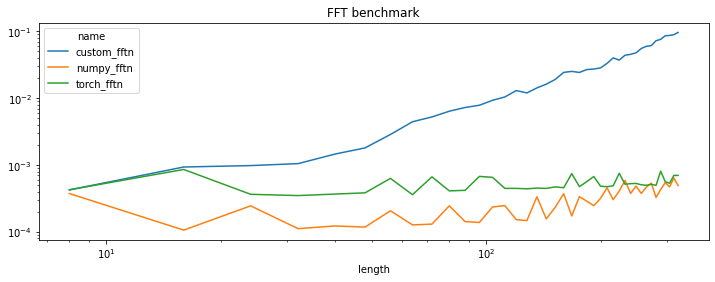

In [71]:
piv.plot(logy=True, logx=True, title="FFT benchmark", figsize=(12, 4));

## Profiling

In [72]:
from pyquickhelper.pycode.profiling import profile2graph, profile

shape = [4, 131]
fft_length = [128]
axes = [1]

def f():
    for i in range(100):
        custom_fftn(rnd, 'FFT', fft_length, axes)

stat, text = profile(f)
gr = profile2graph(stat)
print(gr[0].to_text(fct_width=40))

f                                        --    1    1 -- 0.00017 0.13530 -- <ipython-input-72-0b9ed5a82854>:7:f (f)
    custom_fftn                          --  100  100 -- 0.00064 0.13513 -- <ipython-input-68-a6efd5215b48>:55:custom_fftn (custom_fftn)
        custom_fft                       --  100  100 -- 0.00664 0.13445 -- <ipython-input-68-a6efd5215b48>:20:custom_fft (custom_fft)
            _dft_cst                     --  100  100 -- 0.00054 0.12676 -- <ipython-input-68-a6efd5215b48>:4:_dft_cst (_dft_cst)
                _arange                  --  200  200 -- 0.00028 0.00131 -- <ipython-input-68-a6efd5215b48>:5:_arange (_arange)
                    <method '...objects> --  200  200 -- 0.00046 0.00046 -- ~:0:<method 'astype' of 'numpy.ndarray' objects> (<method 'astype' of 'numpy.ndarray' objects>)
                    <method '...objects> --  200  200 -- 0.00022 0.00022 -- ~:0:<method 'reshape' of 'numpy.ndarray' objects> (<method 'reshape' of 'numpy.ndarray' objects>)
        